# TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK

Tutorial from:
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We’ll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count to use to later replace rare words

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English I added the reverse flag to reverse the pairs.

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['je suis simplement franche .', 'i m just being honest .']


## THE SEQ2SEQ MODEL

A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

<img src="seq2seq.png">

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.

## The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

<img src="encoder-network.png">

In [2]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## The Decoder

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

**Simple Decoder** <br>
In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

<img src="decoder-network.png">

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## TRAINING

### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training the Model

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn teacher_forcing_ratio up to use more of it.

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [28]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        print(input.shape)
        print(self.embedding(input).shape)
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [29]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        print(ei)
        print(input_lang.index2word[input_tensor[ei].item()])
        print(encoder_output)
        print(encoder_output.shape)
        print(encoder_hidden)
        print(encoder_output[0, 0])
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [30]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(2)]
    criterion = nn.NLLLoss()

    for iter in range(1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        
    return loss

In [31]:
hidden_size = 6
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 1, print_every=100000)

torch.Size([1])
torch.Size([1, 6])
0
je
tensor([[[-0.3206, -0.3668, -0.1606, -0.0799, -0.2241, -0.0877]]], device='cuda:0')
torch.Size([1, 1, 6])
tensor([[[-0.3206, -0.3668, -0.1606, -0.0799, -0.2241, -0.0877]]], device='cuda:0')
tensor([-0.3206, -0.3668, -0.1606, -0.0799, -0.2241, -0.0877], device='cuda:0')
torch.Size([1])
torch.Size([1, 6])
1
quitte
tensor([[[-0.3744, -0.2227, -0.2728,  0.1531, -0.4546,  0.0205]]], device='cuda:0')
torch.Size([1, 1, 6])
tensor([[[-0.3744, -0.2227, -0.2728,  0.1531, -0.4546,  0.0205]]], device='cuda:0')
tensor([-0.3744, -0.2227, -0.2728,  0.1531, -0.4546,  0.0205], device='cuda:0')
torch.Size([1])
torch.Size([1, 6])
2
le
tensor([[[ 0.1013, -0.0958,  0.0230,  0.3893, -0.3579,  0.0704]]], device='cuda:0')
torch.Size([1, 1, 6])
tensor([[[ 0.1013, -0.0958,  0.0230,  0.3893, -0.3579,  0.0704]]], device='cuda:0')
tensor([ 0.1013, -0.0958,  0.0230,  0.3893, -0.3579,  0.0704], device='cuda:0')
torch.Size([1])
torch.Size([1, 6])
3
japon
tensor([[[ 0.2139,  0.1

8.016006469726562

In [10]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [11]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting
- Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [12]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

In [13]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## EVALUATION

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### TRAINING AND EVALUATING

With all these helper functions in place (it looks like extra work, but it makes it easier to run multiple experiments) we can actually initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small dataset we can use relatively small networks of 256 hidden nodes and a single GRU layer. After about 40 minutes on a MacBook CPU we’ll get some reasonable results.

0m 0s (- 0m 1s) (10 10%) 5.1633
0m 0s (- 0m 0s) (20 20%) 3.8583
0m 0s (- 0m 0s) (30 30%) 3.8765
0m 0s (- 0m 0s) (40 40%) 4.3686
0m 0s (- 0m 0s) (50 50%) 3.7786
0m 0s (- 0m 0s) (60 60%) 3.4479
0m 0s (- 0m 0s) (70 70%) 4.1532
0m 0s (- 0m 0s) (80 80%) 3.7952
0m 1s (- 0m 0s) (90 90%) 4.0222
0m 1s (- 0m 0s) (100 100%) 3.6763


<Figure size 432x288 with 0 Axes>

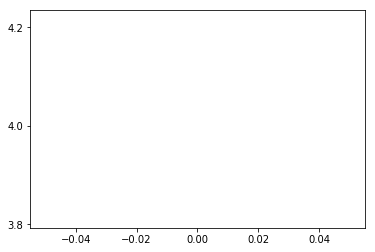

In [17]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 100, print_every=10)

In [21]:
evaluateRandomly(encoder1, decoder1)

> je suis enchante de vous rencontrer .
= i m delighted to meet you .
< i re . <EOS>

> vous etes un chic type .
= you are a good person .
< i re . <EOS>

> il a peur des serpents .
= he s afraid of snakes .
< i re . <EOS>

> maintenant j ai des ennuis .
= i m in trouble now .
< i re . <EOS>

> je vais aller chercher a manger .
= i m going to go get some food .
< i re . <EOS>

> vous etes fort attirant .
= you re very attractive .
< i re . <EOS>

> il est toujours celibataire .
= he s still single .
< i re . <EOS>

> je suis desole si je vous ai effrayees .
= i m sorry if i frightened you .
< i re . <EOS>

> nous avons tous deux raison .
= we re both right .
< i re . <EOS>

> je crains que vous vous perdiez .
= i am afraid that you will get lost .
< i re . <EOS>

